# Model 2: Neural Style Transfer with Transfer Learning

This notebook uses the transfer learning model train in Notebook: Model_2 TL_Training, to do Neutral Style Transfer for input content & style images

In [1]:
#Import libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt

import numpy as np

import keras
import tensorflow as tf

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Model,load_model,Sequential
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.python.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback

from keras.preprocessing.image import load_img, img_to_array
from keras import models

import IPython.display as display
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import PIL.Image
import time
import functools
import cv2 as cv

%matplotlib inline

Using TensorFlow backend.


In [2]:
#Define function to convert tensor to image
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# Define a function to load an image and limit its maximum dimension to 512 pixels.
def load_image(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

#Define a function to show image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

#Define a function that load the trained transfer learning model & return output of input layer name
def model_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  model = load_model('./TL_Trained_Model/vgg19_1_model.h5')
  model.load_weights('./TL_Trained_Model/vgg19_1_weight.h5')

  outputs = [model.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([model.input], outputs)
  return model

#To clip value of image within 0 to 1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

## Read and Visualize input

In [3]:
#Choose content and style path
target_image_path = './img/shophouse.jpg'
style_reference_image_path = './img/wgz3.jpg'

#find width & height of content image
width, height = load_img(target_image_path).size

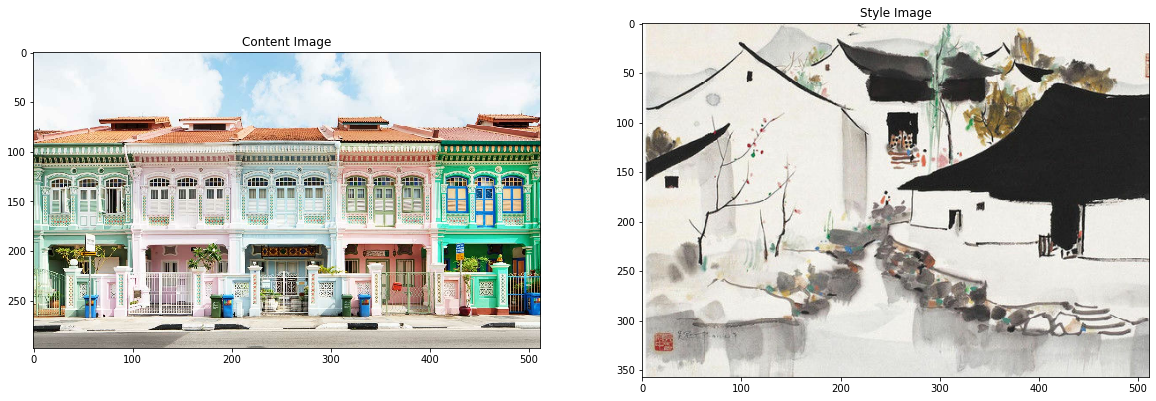

In [4]:
#load images
content_image = load_image(target_image_path)
style_image = load_image(style_reference_image_path)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [8]:
#load and display layer names in trained model
model = load_model('./TL_Trained_Model/vgg19_1_model.h5')
model.load_weights('./TL_Trained_Model/vgg19_1_weight.h5')

print()
for layer in model.layers:
  print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
conv2d_2
max_pooling2d_2
global_average_pooling2d_1
dense_2
dense_3


Choose intermediate layers from the network to represent the style and content of the image:


In [9]:
# Content layer where will pull feature maps
content_layers = ['block4_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1',
                'conv2d_2']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model 

In [10]:
style_extractor = model_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 357, 512, 64)
  min:  0.0
  max:  869.1682
  mean:  30.893353

block2_conv1
  shape:  (1, 178, 256, 128)
  min:  0.0
  max:  4271.225
  mean:  184.6392

block3_conv1
  shape:  (1, 89, 128, 256)
  min:  0.0
  max:  10298.848
  mean:  167.6085

block4_conv1
  shape:  (1, 44, 64, 512)
  min:  0.0
  max:  20813.98
  mean:  672.8536

block5_conv1
  shape:  (1, 22, 32, 512)
  min:  0.0
  max:  2940.6287
  mean:  54.11371

conv2d_2
  shape:  (1, 11, 16, 512)
  min:  0.0
  max:  92.14601
  mean:  2.0993273



### Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calcualted for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [11]:
#Define Gram Matrix function
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

### Extract style and content


Build a model that returns the style and content tensors.

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  model_layers(style_layers + content_layers) #build a model (named vgg) which extract layer output of style & content layer
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) #preprocess image with vgg19 preprocess function
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    #Find gram matrix of style layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]
    
    #Find name & value of content layer output
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    #Find name & value of style layer output
    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [0]:
#When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:
extractor = StyleContentModel(style_layers, content_layers)

#Extract gram matrix value of style layer and output of content layer from input content image
results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


## Run gradient descent

Gradient descent of neural style transfer can be done by calculating the mean square error for input image's output relative to each target, then take the weighted sum of these losses.

In [0]:
#Set style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [0]:
#Create an optimizer with Adam optimiser
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.9, epsilon=1e-2)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [0]:
#Initiate weighted parameters, which is a constant value
style_weight=30 
content_weight=6000
total_variation_weight=5

#One downside to this method of styel transfer is it produces a lot of high frequency artifacts,
#which can be decreased using an explicit regularization term on the high frequency components of the image. 
#In style transfer, this is often called the *total variation loss*

In [0]:
#Define function to calculate loss function for neural style transfer
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    #Find mean square loss of gram matrix values of all style layers
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    
    #Find style loss by multiplying with (Style weight/no. of style layer), equation given in readme
    style_loss *= style_weight / num_style_layers

    #Find mean square loss of content layer
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    #Find content loss by multiplying with (content weight/no. of content layer), equation give in readme
    content_loss *= content_weight / num_content_layers
    
    #Find total loss
    loss = style_loss + content_loss
    
    return loss

## Run Neural Style Transfer

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    #Add total variation loss
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [0]:
#Initiate contant image 
image = tf.Variable(content_image)

In [0]:
start = time.time()

epochs = 45 #No. of times to run the style transfer
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Saving Result

In [0]:
#Convert to image from tensor
image_final = tensor_to_image(image)
#Denoise image with opencv function
image_final = cv.fastNlMeansDenoisingColored(np.array(image_final),None,7,7,7,21)
#Resize image to size of original content image with opencv function
image_final = cv.resize(image_final, (width, height), interpolation = cv.INTER_AREA)
#Show final image
plt.imshow(image_final)

In [0]:
# save the image
plt.imsave('./TL_model_img/NST06_shtest.png', image_final)